# Forecast Model Analysis


In [2]:
import functions as sf
import pandas as pd

In [5]:
df = pd.read_csv('../data/weight.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.head()

,weight_lbs,exer,food,avg_7d
date,,,,
2024-11-19,160.4,1,5,160.00
2024-11-20,159.2,1,6,160.00
2024-11-21,159.0,0,5,160.03
2024-11-22,159.2,1,6,159.86
2024-11-23,159.0,0,5,159.66


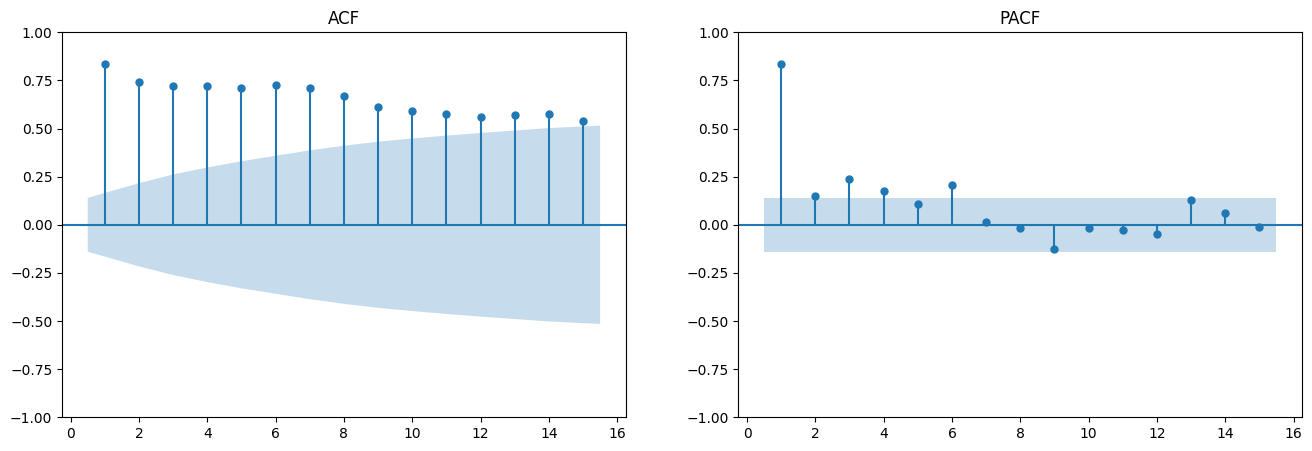

In [6]:
Y = df['weight_lbs']
sf.all_ac(Y)

In [7]:
sf.stationarity_test(Y)

('Non-Stationarity', 'Non-Stationarity')